In [247]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections import OrderedDict

In [250]:
PATH = 'data/'
TRAIN_PATH = PATH+'train_cleaned.csv'
TEST_PATH = PATH+'test_cleaned.csv'

In [251]:
train_db = pd.read_csv(TRAIN_PATH)
test_db = pd.read_csv(TEST_PATH)

In [252]:
train_db.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,65.0,8450,7,5,2003,2,196.0,3,2,4,...,1,0,0,0,0,0,0,0,0,0
1,80.0,9600,6,8,1976,0,0.0,2,2,4,...,0,0,0,0,0,0,0,0,0,0
2,68.0,11250,7,5,2001,2,162.0,3,2,4,...,1,0,0,0,0,0,0,0,0,0
3,60.0,9550,7,5,1915,0,0.0,2,2,3,...,0,1,0,0,0,0,0,0,0,0
4,84.0,14260,8,5,2000,2,350.0,3,2,4,...,1,0,0,0,0,0,0,0,0,0


In [128]:
numeric_variables = ['LotFrontage','LotArea','YearBuilt','MasVnrArea','BsmtFinSF1','BsmtUnfSF',
                     'TotalBsmtSF','2ndFlrSF','GrLivArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                    '3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold','TotalBath','Age']

In [123]:
# Extract the datasets
y_train= train_db['SalePrice']
X_train = train_db.drop(columns=['SalePrice'])
X_test = test_db

In [124]:
# Print size of train and test data
print('Size of training data:{0}'.format(X_train.shape[0]))
print('Size of test data:{0}'.format(X_test.shape[0]))
print('Number of variables in training data: {0}'.format(X_train.shape[1]))
print('Number of variables in test data: {0}'.format(X_test.shape[1]))

Size of training data:1458
Size of test data:1459
Number of variables in training data: 164
Number of variables in test data: 164


In [125]:
# Skew of SalePrice
y_train.skew()

1.8812964895244009

In [126]:
# Correct the skew of the distribution
y_train.loc[:] = np.log(y_train.values)
y_train.skew()

0.12156821443518166

In [130]:
# Remove the skew from numerical variables
for var in numeric_variables:
    if X_train[var].skew() > 0.8:
        X_train[var].loc[:] = np.log(X_train[var].values.astype(float)+1)
        X_test[var].loc[:] = np.log(X_test[var].values.astype(float)+1)

In [131]:
from sklearn import preprocessing

In [132]:
scaler = preprocessing.RobustScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [133]:
scaler_y = preprocessing.RobustScaler().fit(y_train.reshape(-1,1))
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1))

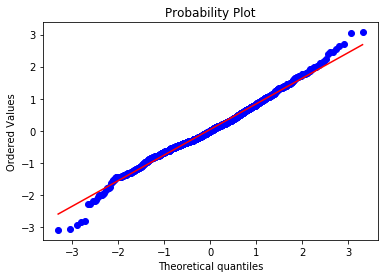

In [134]:
import scipy.stats as stats
stats.probplot(np.squeeze(y_train_scaled), dist='norm', plot = plt)
plt.show()

In [143]:
# Import Libraries
# Import models
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb

# Utilities for building and selecting model
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error



In [167]:
# Cross validation of model
n_folds = 5 # 5 fold cross validation

def metric_cv(model,metric='RMSE'):
    X = X_train
    y = y_train
    kf = KFold(n_folds, shuffle = True, random_state=42).get_n_splits(X)
    if metric == 'RMSE':
        rmse = np.sqrt(-cross_val_score(model,X,y,scoring='neg_mean_squared_error',cv=kf))
        return (rmse)
    else:
        #TODO
        return(100.0)


#### Base Models

In [168]:
# LASSO Regression
lasso = make_pipeline(preprocessing.RobustScaler(),Lasso(alpha = 0.0005, random_state = 1))

In [172]:
# ElasticNetRegression
enet = make_pipeline(preprocessing.RobustScaler(),ElasticNet(alpha = 0.0005, l1_ratio = 0.9, random_state = 1))

In [173]:
# KernelRidgeRegression
krr = KernelRidge(alpha=0.6, kernel = 'polynomial', degree = 2, coef0 = 2.5)

In [175]:
# GradientBoostingRegression
gboost = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05, 
                                   max_depth = 4, max_features = 'sqrt',
                                  min_samples_leaf = 15, min_samples_split = 10,
                                  loss = 'huber', random_state = 1)


In [177]:
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =1, nthread = -1)

#### Base Model Scores

In [178]:
scores = metric_cv(lasso)
print('Lasso model scores, mean {0:.4f}, std {1:.4f}'.format(scores.mean(),scores.std()))

Lasso model scores, mean 0.1114, std 0.0050


In [180]:
scores = metric_cv(enet)
print('ElasticNet model scores, mean {0:.4f}, std {1:.4f}'.format(scores.mean(),scores.std()))

ElasticNet model scores, mean 0.1115, std 0.0050


In [181]:
scores = metric_cv(krr)
print('KernelRidge model scores, mean {0:.4f}, std {1:.4f}'.format(scores.mean(),scores.std()))

KernelRidge model scores, mean 0.2185, std 0.0117


In [182]:
scores = metric_cv(gboost)
print('Gradient Boosting model scores, mean {0:.4f}, std {1:.4f}'.format(scores.mean(),scores.std()))

Gradient Boosting model scores, mean 0.1171, std 0.0052


In [183]:
scores = metric_cv(model_xgb)
print('Xgboost model scores, mean {0:.4f}, std {1:.4f}'.format(scores.mean(),scores.std()))

Xgboost model scores, mean 0.1136, std 0.0055


#### Stacked Models

In [188]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [238]:
# Average predictions from several models
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models,weights):
        self.models = models
        
        weights = np.asarray(weights)
        self.weights = 1.0*weights/sum(weights)
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X,y)
        
        return(self)
    
    def predict(self,X):
        
        w = self.weights
        predictions = [(model.predict(X)*w[i]) for i, model in enumerate(self.models_)]
        predictions = np.sum(np.column_stack(predictions),axis=1)
        
        return(predictions)

In [245]:
averaged_models = AveragingModels(models = (enet, gboost, lasso), weights = [1.0,1.0,1.0])

In [246]:
scores = metric_cv(averaged_models)
print('Averaged model scores, mean {0:.4f}, std {1:.4f}'.format(scores.mean(),scores.std()))

Averaged model scores, mean 0.1086, std 0.0052
